In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!apt update && apt install -y openslide-tools
!pip install openslide-python
!pip install mean_average_precision

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [55.5 kB]
Hit:12 http://ppa.launchpad.net/cran/

In [3]:
import xml.etree.ElementTree as ET
import pickle
import pandas as pd
import seaborn as sns
import os
from os import listdir, getcwd
from os.path import join
import cv2
import shutil
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps, ImageDraw
import openslide

##Evaluate

In [4]:
metadata = pickle.load(open('/content/gdrive/MyDrive/Yolov5/CMV/metadata_CMV.pkl', 'rb'))

In [ ]:
%cd /content/gdrive/MyDrive/Yolov5/CMV/LabelTest/SN20-32081 A3/FinalNorm/labels

/content/gdrive/MyDrive/Yolov5/CMV/LabelTest/SN20-32081 A3/FinalNorm/labels


In [5]:
def converttominmax(norm_center, top_x, top_y):
  offset = np.array([top_x, top_y, top_x, top_y])
  center = norm_center*512
  minmax = np.array([center[0]-center[2]/2, center[1]-center[3]/2, center[0]+center[2]/2, center[1]+center[3]/2])
  return minmax+offset

In [ ]:
filenames = os.listdir()

In [ ]:
## for the whole slide 
predData = {}
detail = {}
f = 'S20-32081 E1'
predData[f] = []
detail[f] = {}
detail[f]['maskGT'] = []
detail[f]['TP'] = []

In [ ]:
## for the whole Slide
for f in filenames:
  if(len(f.split('.')[0].split('_'))==2):
    filename = 'S20-32081 E1'
    top_x, top_y = f.split('.')[0].split('_')
    top_x, top_y = int(top_x), int(top_y)
    with open(f, 'r') as t:
      for line in t:
        numpylist = np.array(list(map(float, line.split()[1:-1])))
        numpylist = converttominmax(numpylist, top_x, top_y)
        predData[filename].append(np.concatenate((numpylist, np.array([float(line.split()[-1])]))))

predData['S20-32081 E1'] = np.array(predData['S20-32081 E1'])

In [ ]:
## for the train val test set
predData = {}
detail = {}
for filename in filenames:
  f, top_x, top_y = filename.split('.')[0].split('_')
  predData[f] = []
  detail[f] = {}
  detail[f]['maskGT'] = []
  detail[f]['TP'] = []

for f in filenames:
  filename, top_x, top_y = f.split('.')[0].split('_')
  top_x, top_y = int(top_x), int(top_y)
  with open(f, 'r') as t:
    for line in t:
      numpylist = np.array(list(map(float, line.split()[1:-1])))
      numpylist = converttominmax(numpylist, top_x, top_y)
      predData[filename].append(np.concatenate((numpylist, np.array([float(line.split()[-1])]))))

for f in predData:
  predData[f] = np.array(predData[f])   

In [ ]:
## for Last one
predData = {}
detail = {}
for filename in filenames:
  f, top_x, top_y = [filename.split('.')[0]] + filename.split('.')[1].split('_')[1:]
  predData[f] = []
  detail[f] = {}
  detail[f]['maskGT'] = []
  detail[f]['TP'] = []

for f in filenames:
  filename, top_x, top_y = [f.split('.')[0]] + f.split('.')[1].split('_')[1:]
  top_x, top_y = int(top_x), int(top_y)
  with open(f, 'r') as t:
    for line in t:
      numpylist = np.array(list(map(float, line.split()[1:-1])))
      numpylist = converttominmax(numpylist, top_x, top_y)
      predData[filename].append(np.concatenate((numpylist, np.array([float(line.split()[-1])]))))

for f in predData:
  predData[f] = np.array(predData[f])   

In [ ]:
predData

{'SN20-32081 A3': array([[1.03295313e+05, 3.10428951e+04, 1.03414000e+05, 3.11536120e+04,
         2.66859000e-02],
        [1.03301436e+05, 3.09964541e+04, 1.03414000e+05, 3.11104407e+04,
         2.04033000e-02],
        [1.03258822e+05, 3.11578317e+04, 1.03407264e+05, 3.12501253e+04,
         1.25249000e-02],
        ...,
        [1.15962051e+05, 2.08683183e+04, 1.16008193e+05, 2.09402599e+04,
         1.12361000e-02],
        [1.15958000e+05, 2.12489948e+04, 1.16035233e+05, 2.13396982e+04,
         1.07508000e-02],
        [1.16340154e+05, 2.13049782e+04, 1.16424660e+05, 2.13720000e+04,
         1.03705000e-02]])}

#TP or FP

In [ ]:
def bb_intersection_over_union(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])

	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou

In [ ]:
GroundTruthPositive = 0
for filename in predData:
  print(filename)
  GroundTruthPositive += len(metadata['{}.svs'.format(filename)]['bbox'])
  gt = np.array(metadata['{}.svs'.format(filename)]['bbox'])
  p = predData[filename][::, :-1]
  maskGT  = [False for _ in range(len(gt))]
  TP = [False for _ in range(len(p))]

  for i in range(len(p)):
    iou = 0
    maxGT = -1
    for j in range(len(gt)):
      if(not maskGT[j]):
        cur = bb_intersection_over_union(p[i], gt[j])
        if(cur > 0.5 and cur > iou):
          iou = cur
          maxGT = j
    if(maxGT >= 0): 
      TP[i] = True
      maskGT[maxGT] = True
    # print(iou, predData[filename][i, -1])

  detail[filename]['maskGT'] = maskGT
  detail[filename]['TP'] = TP

SN20-32081 A3


In [ ]:
df = pd.DataFrame(columns=['xmin', 'ymin', 'xmax', 'ymax', 'conf', 'TP'])
for filename in predData:
  dtmp = pd.DataFrame(predData[filename], columns=['xmin', 'ymin', 'xmax', 'ymax', 'conf'])
  dtmp['TP'] = detail[filename]['TP']
  df = df.append(dtmp)

In [ ]:
df = df.sort_values(by=['conf'], ascending=False)

In [ ]:
Precision = []
Recall = []
idx = 1.0
TP = 0.0
for _ , row in df.iterrows():
  if(row['TP']): TP+=1
  Precision.append(TP/idx)
  if GroundTruthPositive==0:
    Recall.append(0)
  else:
    Recall.append(TP/GroundTruthPositive)
  idx+=1

In [ ]:
df['Precision'] = Precision
df['Recall'] = Recall

In [ ]:
df['IP'] = df.groupby('Recall')['Precision'].transform('max')

In [ ]:
df

,xmin,ymin,xmax,ymax,conf,TP,Precision,Recall,IP
17426,106497.839232,18482.762496,106581.829248,18561.629952,0.924737,False,0.000000,0.000,0.000000
8580,106498.255232,18483.984384,106582.833536,18558.846464,0.917869,False,0.000000,0.000,0.000000
14100,116269.381504,29195.285248,116343.328640,29277.513472,0.917665,True,0.333333,0.125,0.333333
14676,116267.974528,29194.881536,116343.469952,29278.094336,0.914617,False,0.250000,0.125,0.333333
14137,116269.004416,29195.991552,116343.635072,29277.952000,0.910348,False,0.200000,0.125,0.333333
...,...,...,...,...,...,...,...,...,...
9257,69150.679168,27172.213248,69251.203712,27252.495360,0.010001,False,0.000386,1.000,0.010376
3953,67336.353920,19293.214720,67449.081472,19401.850368,0.010001,False,0.000386,1.000,0.010376
14582,116054.567552,22872.774144,116179.229824,22954.483712,0.010001,False,0.000386,1.000,0.010376
5548,68307.649741,25659.838234,68335.832627,25689.853670,0.010001,False,0.000386,1.000,0.010376


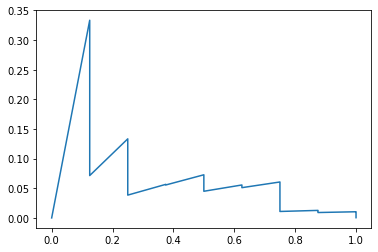

In [ ]:
import matplotlib.pyplot as plt

plt.plot(df['Recall'], df['Precision'])

In [ ]:
prec_at_rec = []

for recall_level in np.linspace(0.0, 1.0, 11):
    try:
        x = df[df['Recall'] >= recall_level]['Precision']
        prec = max(x)
    except:
        prec = 0.0
    prec_at_rec.append(prec)
avg_prec = np.mean(prec_at_rec)
print('11 point precision is ', prec_at_rec)
print('mAP is ', avg_prec)

11 point precision is  [0.3333333333333333, 0.3333333333333333, 0.13333333333333333, 0.07272727272727272, 0.07272727272727272, 0.07272727272727272, 0.06060606060606061, 0.06060606060606061, 0.012681159420289856, 0.010376134889753566, 0.010376134889753566]
mAP is  0.10662066987215785


In [ ]:
np.linspace(0.0, 1.0, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

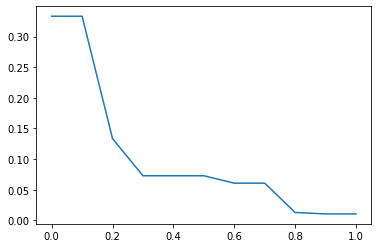

In [ ]:
plt.plot(np.linspace(0.0, 1.0, 11), prec_at_rec)

In [ ]:
df['width'] = df.xmax-df.xmin
df['height'] = df.ymax-df.ymin
df['area'] = df.width*df.height

In [ ]:
df['ratio W/H'] = df.width/df.height

(array([ 194., 1633., 1729., 1672., 1493., 1599., 1465., 1298., 1219.,
        1143., 1018.,  978.,  799.,  676.,  619.,  536.,  475.,  438.,
         336.,  267.,  230.]),
 array([    0,   500,  1000,  1500,  2000,  2500,  3000,  3500,  4000,
         4500,  5000,  5500,  6000,  6500,  7000,  7500,  8000,  8500,
         9000,  9500, 10000, 10500]),
 <a list of 21 Patch objects>)

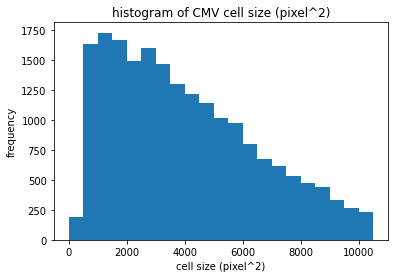

In [ ]:
plt.title('histogram of CMV cell size (pixel^2)')
plt.ylabel('frequency')
plt.xlabel('cell size (pixel^2)')
plt.hist(df.area, bins = np.arange(0, 11000, 500))

In [ ]:
pickle.dump(df, open('/content/gdrive/MyDrive/Yolov5/CMV/DataFrame/FinalNorm/WSI_{}.pkl'.format(f), 'wb'))

# Non Maximum Suppression

In [ ]:
def bb_intersection_over_union(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])

	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou

In [ ]:
def getnewbbox(b, intersect):
  xmin, ymin, xmax, ymax = (np.matmul(intersect[::, :4].transpose(), intersect[::, 4]) + b[:4]*b[4]) / (sum(intersect[::, 4])+b[4])
  conf = (sum(intersect[::, 4])+b[4])/(len(intersect)+1)
  return xmin, ymin, xmax, ymax, conf

In [ ]:
def nms(path, filename, conf=0.5):
  f = filename.split('_')[1].split('.')[0]
  bbox = pickle.load(open(os.path.join(path, filename), 'rb'))
  print(f)

  ls_bbox = np.array(bbox.values.tolist())
  ls_bbox = ls_bbox[ls_bbox[::, 4]>conf]
  keepbox = []

  while len(ls_bbox):
    b = ls_bbox[0, ::]
    ls_bbox = np.delete(ls_bbox, 0, axis=0)

    intersect = []
    for idx, otherb in enumerate(ls_bbox):
      if bb_intersection_over_union(b[:4], otherb) > 0.5:
        intersect.append(idx)
    
    inter_bbox = ls_bbox[intersect]
    xmin, ymin, xmax, ymax, conf = getnewbbox(b, inter_bbox)
    keepbox.append([xmin, ymin, xmax, ymax, conf])
    ls_bbox = np.delete(ls_bbox, intersect, axis=0)

  predData = {}
  detail = {}
  predData[f] = np.array(keepbox)
  detail[f] = {}
  detail[f]['maskGT'] = []
  detail[f]['TP'] = []

  GroundTruthPositive = 0
  for filename in predData:
    if len(predData[filename])==0:
      continue
    GroundTruthPositive += len(metadata['{}.svs'.format(filename)]['bbox'])
    gt = np.array(metadata['{}.svs'.format(filename)]['bbox'])

    p = predData[filename][::, :-1]
    maskGT  = [False for _ in range(len(gt))]
    TP = [False for _ in range(len(p))]

    for i in range(len(p)):
      iou = 0
      maxGT = -1
      for j in range(len(gt)):
        if(not maskGT[j]):
          cur = bb_intersection_over_union(p[i], gt[j])
          if(cur > 0.5 and cur > iou):
            iou = cur
            maxGT = j
      if(maxGT >= 0): 
        TP[i] = True
        maskGT[maxGT] = True
      # print(iou, predData[filename][i, -1])

    detail[filename]['maskGT'] = maskGT
    detail[filename]['TP'] = TP

  df = pd.DataFrame(columns=['xmin', 'ymin', 'xmax', 'ymax', 'conf', 'TP'])
  for filename in predData:
    dtmp = pd.DataFrame(predData[filename], columns=['xmin', 'ymin', 'xmax', 'ymax', 'conf'])
    dtmp['TP'] = detail[filename]['TP']
    df = df.append(dtmp)
  df = df.sort_values(by=['conf'], ascending=False)
  Precision = []
  Recall = []
  idx = 1.0
  TP = 0.0

  for _ , row in df.iterrows():
    if(row['TP']): TP+=1
    Precision.append(TP/idx)
    if GroundTruthPositive==0:
      Recall.append(0)
    else:
      Recall.append(TP/GroundTruthPositive)
    idx+=1

  df['Precision'] = Precision
  df['Recall'] = Recall
  df['IP'] = df.groupby('Recall')['Precision'].transform('max')
  df['width'] = df.xmax-df.xmin
  df['height'] = df.ymax-df.ymin
  df['area'] = df.width*df.height
  df['ratio W/H'] = df.width/df.height
  pickle.dump(df, open('/content/gdrive/MyDrive/Yolov5/CMV/DataFrame/Test/WSI_{}.pkl'.format(f), 'wb'))

In [ ]:
def f2_score_from_file(path):
  data = pd.DataFrame(columns=['xmin', 'ymin', 'xmax', 'ymax', 'conf', 'TP', 'Precision', 'Recall', 'IP', 'width', 'height', 'area', 'ratio W/H'])
  for filename in os.listdir(path):
    if filename.split('.')[-1] == 'pkl':
      data = data.append(pickle.load(open(os.path.join(path, filename), 'rb')))
  data = data.sort_values(by=['conf'], ascending=False)

  GroundTruthPositive = 0
  filenames = ['S20-32081 E1', 'SN20-32081 A1', 'SN20-32081 A2', 'SN20-32081 A3']
  for filename in filenames:
    print(filename)
    GroundTruthPositive += len(metadata['{}.svs'.format(filename)]['bbox'])

  Precision = []
  Recall = []
  idx = 1.0
  TP = 0.0
  for _ , row in data.iterrows():
    if(row['TP']): TP+=1
    Precision.append(TP/idx)
    Recall.append(TP/GroundTruthPositive)
    idx+=1
  data.Precision = Precision
  data.Recall = Recall
  precision = data.Precision.tolist()[-1]
  recall = data.Recall.tolist()[-1]
  score = 5*(precision*recall)/(4*precision+recall)
  return score

S20-32081 E1
SN20-32081 A1
SN20-32081 A2
SN20-32081 A3
S20-32081 E1
SN20-32081 A1
SN20-32081 A2
SN20-32081 A3
S20-32081 E1
SN20-32081 A1
SN20-32081 A2
SN20-32081 A3
S20-32081 E1
SN20-32081 A1
SN20-32081 A2
SN20-32081 A3
S20-32081 E1
SN20-32081 A1
SN20-32081 A2
SN20-32081 A3
S20-32081 E1
SN20-32081 A1
SN20-32081 A2
SN20-32081 A3
S20-32081 E1
SN20-32081 A1
SN20-32081 A2
SN20-32081 A3
S20-32081 E1
SN20-32081 A1
SN20-32081 A2
SN20-32081 A3
S20-32081 E1
SN20-32081 A1
SN20-32081 A2
SN20-32081 A3
S20-32081 E1
SN20-32081 A1
SN20-32081 A2
SN20-32081 A3
S20-32081 E1
SN20-32081 A1
SN20-32081 A2
SN20-32081 A3
S20-32081 E1
SN20-32081 A1
SN20-32081 A2
SN20-32081 A3
S20-32081 E1
SN20-32081 A1
SN20-32081 A2
SN20-32081 A3
S20-32081 E1
SN20-32081 A1
SN20-32081 A2
SN20-32081 A3
S20-32081 E1
SN20-32081 A1
SN20-32081 A2
SN20-32081 A3
S20-32081 E1
SN20-32081 A1
SN20-32081 A2
SN20-32081 A3
S20-32081 E1
SN20-32081 A1
SN20-32081 A2
SN20-32081 A3
S20-32081 E1
SN20-32081 A1
SN20-32081 A2
SN20-32081 A3
S20-32081 

Text(0, 0.5, 'F2 Score')

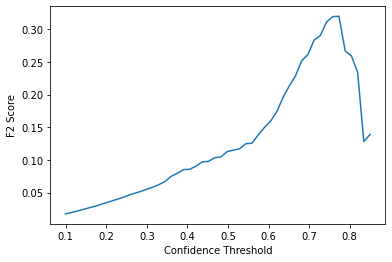

In [ ]:
path = '/content/gdrive/MyDrive/Yolov5/CMV/DataFrame/FinalNorm'
nms_path = '/content/gdrive/MyDrive/Yolov5/CMV/DataFrame/Test'
filenames = os.listdir(path)
x = np.linspace(0.1, 0.85, num=50)
y = []
for conf in x:
  for filename in filenames:
    if filename.split('.')[-1] == 'pkl':
        nms(path, filename, conf)
  y.append(f2_score_from_file(nms_path))


plt.plot(x, y)
plt.xlabel('Confidence Threshold')
plt.ylabel('F2 Score')

Text(0, 0.5, 'F2 Score')

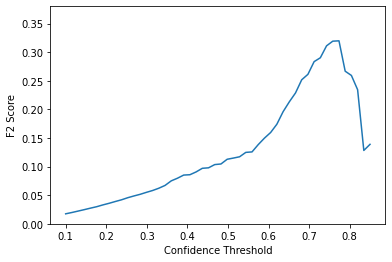

In [ ]:
plt.plot(x, y)
plt.ylim(0, 0.38)
plt.xlabel('Confidence Threshold')
plt.ylabel('F2 Score')

In [ ]:
path = '/content/gdrive/MyDrive/Yolov5/CMV/DataFrame/'
nms_path = '/content/gdrive/MyDrive/Yolov5/CMV/DataFrame/Test'
filenames = os.listdir(path)
for filename in filenames:
  if filename.split('.')[-1] == 'pkl':
    nms(path, filename, 0.1)
f2_score_from_file(nms_path)

SN20-32081 A2
SN20-32081 A3
S20-32081 E1
SN20-32081 A1
S20-32081 E1
SN20-32081 A1
SN20-32081 A2
SN20-32081 A3


0.025957972805933253

In [ ]:
max(y)

0.31976744186046513

In [ ]:
x[np.argmax(np.array(y))]

0.773469387755102

#Load

In [27]:
data = pd.DataFrame(columns=['xmin', 'ymin', 'xmax', 'ymax', 'conf', 'TP', 'Precision', 'Recall', 'IP', 'width', 'height', 'area', 'ratio W/H'])

In [28]:
path = '/content/gdrive/MyDrive/Yolov5/CMV/DataFrame/'
for filename in os.listdir(path):
  if filename.split('.')[-1] == 'pkl':
    data = data.append(pickle.load(open("{}{}".format(path, filename), 'rb')))

In [29]:
data = data.sort_values(by=['conf'], ascending=False)
data

,xmin,ymin,xmax,ymax,conf,TP,Precision,Recall,IP,width,height,area,ratio W/H
6116,142611.094656,11021.842048,142674.960512,11093.427840,0.859851,False,0.000000,0.000000,0.000000,63.865856,71.585792,4571.887884,0.892158
6041,142611.097472,11021.986432,142674.744704,11093.332608,0.855243,True,0.500000,0.111111,0.500000,63.647232,71.346176,4540.986616,0.892090
6154,142610.684032,11021.607040,142674.986112,11093.826688,0.854185,False,0.333333,0.111111,0.500000,64.302080,72.219648,4643.873583,0.890368
6068,142610.999936,11022.294144,142674.740864,11093.338240,0.852751,False,0.250000,0.111111,0.500000,63.740928,71.044096,4528.416608,0.897202
930,116275.310976,29192.773376,116344.566144,29277.729536,0.841605,False,0.000000,0.000000,0.000000,69.255168,84.956160,5883.653133,0.815187
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21901,106688.124032,23010.345216,106796.114560,23113.208064,0.010000,False,0.000330,1.000000,0.005358,107.990528,102.862848,11108.213267,1.049850
102,115120.398720,18596.696064,115199.575424,18653.920768,0.010000,False,0.000330,1.000000,0.005358,79.176704,57.224704,4530.863450,1.383611
12125,76937.544192,6088.788736,76995.769856,6148.855040,0.010000,False,0.000079,0.800000,0.003850,58.225664,60.066304,3497.400434,0.969357
31779,69699.143168,8307.548160,69818.713600,8391.162880,0.010000,False,0.000079,0.800000,0.003850,119.570432,83.614720,9997.848192,1.430017


In [30]:
GroundTruthPositive = 0
filenames = ['S20-32081 E1', 'SN20-32081 A1', 'SN20-32081 A2', 'SN20-32081 A3']
for filename in filenames:
  print(filename)
  GroundTruthPositive += len(metadata['{}.svs'.format(filename)]['bbox'])

Precision = []
Recall = []
idx = 1.0
TP = 0.0
for _ , row in data.iterrows():
  if(row['TP']): TP+=1
  Precision.append(TP/idx)
  Recall.append(TP/GroundTruthPositive)
  idx+=1

S20-32081 E1
SN20-32081 A1
SN20-32081 A2
SN20-32081 A3


In [31]:
data.Precision = Precision
data.Recall = Recall

In [32]:
data['IP'] = data.groupby('Recall')['Precision'].transform('max')

In [33]:
data

,xmin,ymin,xmax,ymax,conf,TP,Precision,Recall,IP,width,height,area,ratio W/H
6116,142611.094656,11021.842048,142674.960512,11093.427840,0.859851,False,0.000000,0.000000,0.000000,63.865856,71.585792,4571.887884,0.892158
6041,142611.097472,11021.986432,142674.744704,11093.332608,0.855243,True,0.500000,0.045455,0.500000,63.647232,71.346176,4540.986616,0.892090
6154,142610.684032,11021.607040,142674.986112,11093.826688,0.854185,False,0.333333,0.045455,0.500000,64.302080,72.219648,4643.873583,0.890368
6068,142610.999936,11022.294144,142674.740864,11093.338240,0.852751,False,0.250000,0.045455,0.500000,63.740928,71.044096,4528.416608,0.897202
930,116275.310976,29192.773376,116344.566144,29277.729536,0.841605,False,0.200000,0.045455,0.500000,69.255168,84.956160,5883.653133,0.815187
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21901,106688.124032,23010.345216,106796.114560,23113.208064,0.010000,False,0.000157,0.954545,0.002854,107.990528,102.862848,11108.213267,1.049850
102,115120.398720,18596.696064,115199.575424,18653.920768,0.010000,False,0.000157,0.954545,0.002854,79.176704,57.224704,4530.863450,1.383611
12125,76937.544192,6088.788736,76995.769856,6148.855040,0.010000,False,0.000157,0.954545,0.002854,58.225664,60.066304,3497.400434,0.969357
31779,69699.143168,8307.548160,69818.713600,8391.162880,0.010000,False,0.000157,0.954545,0.002854,119.570432,83.614720,9997.848192,1.430017


In [34]:
prec_at_rec = []

for recall_level in np.linspace(0.0, 1.0, 11):
    try:
        x = data[data['Recall'] >= recall_level]['Precision']
        prec = max(x)
    except:
        prec = 0.0
    prec_at_rec.append(prec)
avg_prec = np.mean(prec_at_rec)
print('11 point precision is ', prec_at_rec)
print('mAP is ', avg_prec)

11 point precision is  [0.5, 0.375, 0.14285714285714285, 0.08235294117647059, 0.044642857142857144, 0.043824701195219126, 0.022222222222222223, 0.0214190093708166, 0.008152173913043478, 0.0054466230936819175, 0.0]
mAP is  0.11326524281558671


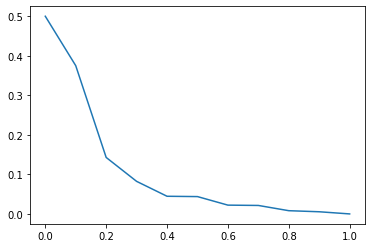

In [35]:
plt.plot(np.linspace(0.0, 1.0, 11), prec_at_rec)

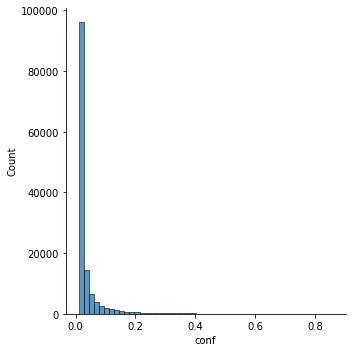

In [ ]:
sns.displot(data=data.conf, bins=50)

Text(0.5, 6.79999999999999, 'cell size (pixel^2)')

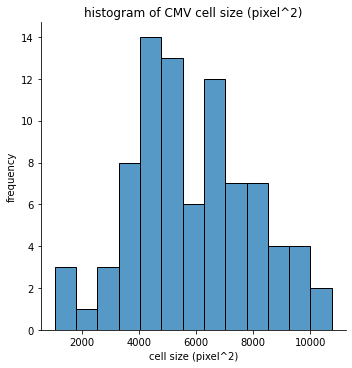

In [ ]:
sns.displot(data=data.area[data.conf > 0.721], bins=13)
plt.title('histogram of CMV cell size (pixel^2)')
plt.ylabel('frequency')
plt.xlabel('cell size (pixel^2)')
# plt.xlim(0, 10000)

In [ ]:
sum(data['ratio W/H']==float('inf'))

50

In [ ]:
ratioData = np.array(data['ratio W/H'])[data.conf > 0.721]
ratioData = ratioData[ratioData!=float('inf')]

Text(0.5, 6.79999999999999, 'ratio')

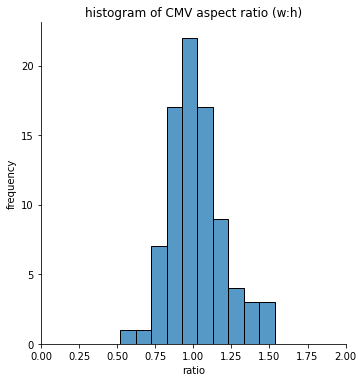

In [ ]:
sns.displot(data=ratioData, bins=10)
plt.xlim(0, 2)
plt.title('histogram of CMV aspect ratio (w:h)')
plt.ylabel('frequency')
plt.xlabel('ratio')

In [ ]:
def f2_score(data, conf_threshold):
  if(len(np.array(data.Recall)[np.array(data.conf)>conf_threshold])==0): return 0
  recall = np.array(data.Recall)[np.array(data.conf)>conf_threshold][-1]
  precision = np.array(data.Precision)[np.array(data.conf)>conf_threshold][-1]

  score = 5*(precision*recall)/(4*precision+recall)
  return score

Text(0, 0.5, 'F2 Score')

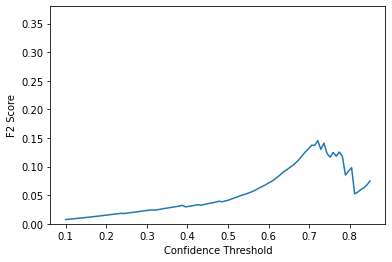

In [ ]:
x = np.linspace(0.1, 0.85, num=100)
y = []
for conf in x:
  y.append(f2_score(data, conf))

plt.plot(x, y)
plt.ylim(0, 0.38)
plt.xlabel('Confidence Threshold')
plt.ylabel('F2 Score')

In [ ]:
print(max(y))

0.31976744186046513


In [ ]:
x[np.argmax(np.array(y))]

0.773469387755102

In [ ]:
precision = data.Precision[data.conf > 0.721].tolist()[-1]
recall = data.Recall[data.conf > 0.721].tolist()[-1]
score = 5*(precision*recall)/(4*precision+recall)
print('Score: {}'.format(score))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))

Score: 0.31976744186046513
Precision: 0.13095238095238096
Recall: 0.5


In [ ]:
def numFalsePositive(data, conf_threshold):
  result = sum(np.array(data.TP)[np.array(data.conf)>conf_threshold]==False)
  return result

Text(0, 0.5, 'Number of False Positive')

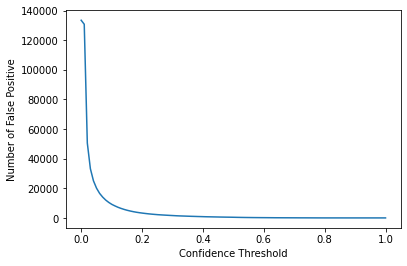

In [ ]:
x = np.linspace(0, 1, num=100)
y = []
for conf in x:
  y.append(numFalsePositive(data, conf))

plt.plot(x, y)
plt.xlabel('Confidence Threshold')
plt.ylabel('Number of False Positive')

In [ ]:
filenames = ['S20-32081 E1', 'SN20-32081 A1', 'SN20-32081 A2', 'SN20-32081 A3']
w = []
h = []
area = []
asp = []
for filename in filenames:
  for xmin, ymin, xmax, ymax in metadata['{}.svs'.format(filename)]['bbox']:
    w.append(xmax-xmin)
    h.append(ymax-ymin)
    area.append((xmax-xmin)*(ymax-ymin))
    asp.append((xmax-xmin)/(ymax-ymin))

Text(0.5, 6.79999999999999, 'cell size (pixel^2)')

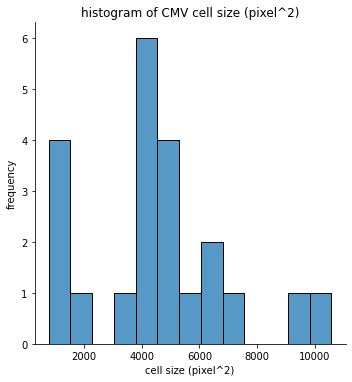

In [ ]:
sns.displot(data=area, bins=13)
plt.title('histogram of CMV cell size (pixel^2)')
plt.ylabel('frequency')
plt.xlabel('cell size (pixel^2)')

Text(0.5, 6.79999999999999, 'ratio')

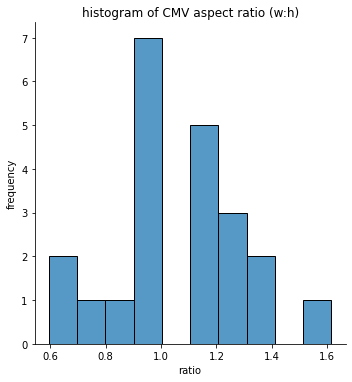

In [ ]:
sns.displot(data=asp, bins=10)
# plt.xlim(0, 2)
plt.title('histogram of CMV aspect ratio (w:h)')
plt.ylabel('frequency')
plt.xlabel('ratio')

#Error Analysis for NMS

In [ ]:
filenames = ['S20-32081 E1', 'SN20-32081 A1', 'SN20-32081 A2', 'SN20-32081 A3']
slide = filenames[0]
path = '/content/gdrive/MyDrive/Yolov5/CMV/DataFrame/Test/'
GroundTruthBBox = np.array(metadata['{}.svs'.format(slide)]['bbox'])

data = pickle.load(open(os.path.join(path, 'WSI_'+slide)+'.pkl', 'rb'))
pos = data.astype('int').iloc[:, :4].to_numpy()
pred_bbox = data.iloc[:, :5].to_numpy()
top = ((pos//256)[:, :2] * 256).tolist()

bbox = {}
for top_x, top_y in top:
  bbox['_'.join([str(top_x), str(top_y)])] = []

for i in range(len(top)):
  bbox["_".join([str(top[i][0]), str(top[i][1])])].append(pred_bbox[i])

In [ ]:
wsi = openslide.OpenSlide("/content/gdrive/MyDrive/Yolov5/CMV/WSI/{}.svs".format(slide))
for p in bbox:
  top_x, top_y = map(int, p.split('_'))
  img = Image.fromarray(np.array(wsi.read_region((top_x, top_y), 0, (512, 512))))
  draw = ImageDraw.Draw(img)

  offset = GroundTruthBBox[::, :2] - np.array([top_x, top_y])
  gt = []
  for i, ls in enumerate(offset):
    if 0<=ls[0] and ls[0]<=512 and 0<=ls[1] and ls[1]<=512:
      gt.append(i)
  
  if len(gt)==0:
    continue

  print(gt)
  for idx in gt:
    xy = list(GroundTruthBBox[idx]-np.array([top_x, top_y, top_x, top_y]))
    draw.rectangle(xy, outline=(71, 255, 38), width=2)

  for xy in bbox[p]:
    minmax = [int(xy[0])-top_x, int(xy[1])-top_y, int(xy[2])-top_x, int(xy[3])-top_y]
    conf = round(xy[4], 3)
    draw.rectangle(minmax, outline='blue')
    draw.text(minmax[:2], str(conf), fill='black')


  display(img)

#Error Analysis

In [6]:
slide = 'S20-32081 E1'
filepath = '/content/gdrive/MyDrive/Yolov5/CMV/LabelTest/{}/FinalNorm/labels'.format(slide)
filenames = sorted(os.listdir(filepath))

metadata = pickle.load(open('/content/gdrive/MyDrive/Yolov5/CMV/metadata_CMV.pkl', 'rb'))
wsi = openslide.OpenSlide("/content/gdrive/MyDrive/Yolov5/CMV/WSI/{}.svs".format(slide))
GroundTruthBBox = np.array(metadata['{}.svs'.format(slide)]['bbox'])

In [37]:
GroundTruthBBox

array([[ 5125, 10346,  5163, 10374],
       [ 3290,  8317,  3312,  8354],
       [44956, 13615, 44987, 13640],
       [44633, 14260, 44677, 14299],
       [72601, 14173, 72643, 14209]])

In [7]:
gt_idx = []
for idx, filename in enumerate(filenames):
  # top = np.array(list(map(int, filename.split('.')[1].split('_')[1:]))) # A1, A2 Format
  # top = np.array(list(map(int, filename.split('.')[0].split('_')))) # E1 Format
  top = np.array(list(map(int, filename.split('.')[0].split('_')[1:]))) # A3 Format
  offset = GroundTruthBBox[::, :2] - top
  gt = []
  for i, ls in enumerate(offset):
    if 0<=ls[0] and ls[0]<512 and 0<=ls[1] and ls[1]<512:
      gt.append(i)
  if len(gt)>0:
    gt_idx.append(idx)
print(gt_idx)

[528, 529, 534, 535, 809, 810, 842, 843, 844, 845, 879, 880, 1399, 1416, 1698, 1714, 2020, 2021, 2041, 2042]


In [ ]:
conf_idx = []
for idx, filename in enumerate(filenames):
  txt_bbox = open(os.path.join(filepath, filename), 'rb')
  encode = 'utf8'
  bbox = [str(i, encode) for i in txt_bbox]

  confbbox = []
  for b in bbox:
    conf = round(list(map(float, b.split()))[-1], 3)
    confbbox.append(conf)
  confbbox = np.array(confbbox)
  if np.sum(confbbox>0.4):
    conf_idx.append(idx)
print(conf_idx)

[42, 43, 498, 499, 579, 580, 588, 634, 635, 726, 727, 918, 919, 935, 939, 940, 1031, 1053, 1054, 1055, 1056, 1128, 1153, 1154, 1155, 1156, 1231, 1232, 1248, 1249, 1338, 1356, 1357, 1388, 1394, 1418, 1424, 1444, 1463, 1484, 1501, 1529, 1535, 1568, 1605, 1606, 1628, 1629, 1639, 1831, 2000, 2093, 2095, 2112, 2362, 2363, 2408, 2491, 2549, 2550, 2607, 2608, 2642, 2666, 2667, 2673, 2674, 2724, 2727, 2746, 2747, 2801, 2844, 3131, 3132, 3152, 3153, 3270, 3464, 3465, 3596, 3597, 3647, 3648, 3656, 3657, 3681, 3682, 3747, 3748, 3881, 3882, 3952, 3953, 3966, 3967, 4041, 4042, 4240, 4241, 4284, 4303, 4304, 4398, 4399, 4567, 4589, 4640, 4683, 5593, 5594]


In [8]:
def generate_predict(idx, format):
  txt_bbox = open(os.path.join(filepath, filenames[idx]), 'rb')
  if format in ['E1']:
    top_x, top_y = map(int, filenames[idx].split('.')[0].split('_'))
  elif format in ['A1', 'A2']:
    top_x, top_y = map(int, filenames[idx].split('.')[1].split('_')[1:])
  elif format in ['A3']:
    top_x, top_y = map(int, filenames[idx].split('.')[0].split('_')[1:])
  img = Image.fromarray(np.array(wsi.read_region((top_x, top_y), 0, (512, 512))))
  draw = ImageDraw.Draw(img)
  print(top_x, top_y)

  ###Draw Ground Truth Box
  offset = GroundTruthBBox[::, :2] - np.array([top_x, top_y])
  gt = []
  for i, ls in enumerate(offset):
    if 0<=ls[0] and ls[0]<=512 and 0<=ls[1] and ls[1]<=512:
      gt.append(i)

  print(gt)
  for idx in gt:
    xy = list(GroundTruthBBox[idx]-np.array([top_x, top_y, top_x, top_y]))
    draw.rectangle(xy, outline=(71, 255, 38), width=2)
  ##########################

  ###Draw Predicted Box#####
  encode = 'utf8'
  bbox = [str(i, encode) for i in txt_bbox]
  for b in bbox:
    norm_center = np.array(list(map(float, b.split()))[1:-1])
    conf = round(list(map(float, b.split()))[-1], 3)
    minmax = list(map(int, converttominmax(norm_center, 0, 0)))
    color = (0, 0, 0)
    if conf > 0.2:
      draw.rectangle(minmax, outline='blue')
      draw.text(minmax[:2], str(conf), fill='black')
    else:
      draw.rectangle(minmax, outline='purple')
      draw.text(minmax[:2], str(conf), fill='black')
  ##########################

  # plt.figure(figsize=(10, 10))
  # plt.imshow(img)
  return img, top_x, top_y

In [ ]:
len(conf_idx)

193

In [ ]:
for idx in conf_idx:
  img, top_x, top_y = generate_predict(idx, "A2")
  # img.save(os.path.join('/content/gdrive/MyDrive/Yolov5/CMV/Error Analysis/{}'.format(slide), '{}_{}_{}.png'.format(slide, top_x, top_y)))
  print(os.path.join('/content/gdrive/MyDrive/Yolov5/CMV/Error Analysis/{}'.format(slide), '{}_{}_{}.png'.format(slide, top_x, top_y)))
  display(img)

In [9]:
for idx in gt_idx:
  img, top_x, top_y = generate_predict(idx, "A3")
  # img.save(os.path.join('/content/gdrive/MyDrive/Yolov5/CMV/Error Analysis/{}'.format(slide), '{}_{}_{}.png'.format(slide, top_x, top_y)))
  print(os.path.join('/content/gdrive/MyDrive/Yolov5/CMV/Error Analysis/{}'.format(slide), '{}_{}_{}.png'.format(slide, top_x, top_y)))
  display(img)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
pickle.dump(conf_idx, open('/content/gdrive/MyDrive/Yolov5/CMV/Error Analysis/SN20-32081 A1_idx_wogt.pkl', 'wb'))